#### TMDB Box Office Prediction:
* Description: In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall
worldwide box office revenue.
* Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.
* You can also collect other public data to make the prediction.

##### Download the data through the API

`! pip install kaggle`  
`! kaggle competitions download -c tmdb-box-office-prediction`

For this, we need to ensure that the necessary requirements are setup accordingly. More information [here](https://github.com/Kaggle/kaggle-api).

### !!! IMPORTANT

- https://www.kaggle.com/code/praxitelisk/tmdb-box-office-prediction-eda-ml/notebook (indepth analysis: mostly use this for our project).
- https://medium.com/@prabhakaran_arivalagan/kaggle-competition-tmdb-box-office-prediction-using-random-forest-a2059be7bfff (bit more intuitive)
- https://github.com/nickmitch21/TMDB-Box-Office-Prediction/tree/master (other people's attempts)

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

train =pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")

In [127]:
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

Shape of training data: (3000, 23)
Shape of testing data: (4398, 22)


In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [129]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [130]:
test.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482242,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


In [131]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [132]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [133]:
#majority are null for these columns, so we remove these columns

train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

train.drop(['homepage'], axis=1, inplace=True)
test.drop(['homepage'], axis=1, inplace=True)

#irrelevant to our purpose
train.drop(['imdb_id'], axis=1, inplace=True)
test.drop(['imdb_id'], axis=1, inplace=True)

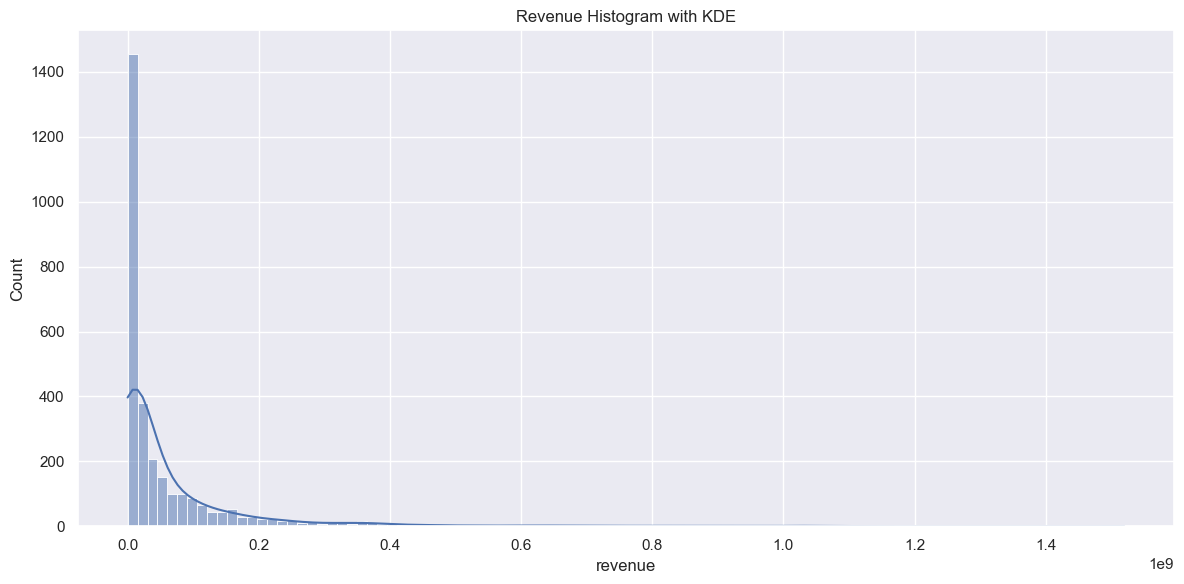

In [134]:
#revenue distrbution
f, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(train.revenue, kde=True, bins=100)  
ax.set_title("Revenue Histogram with KDE")
f.tight_layout()

train["log_revenue"] = np.log1p(train["revenue"])

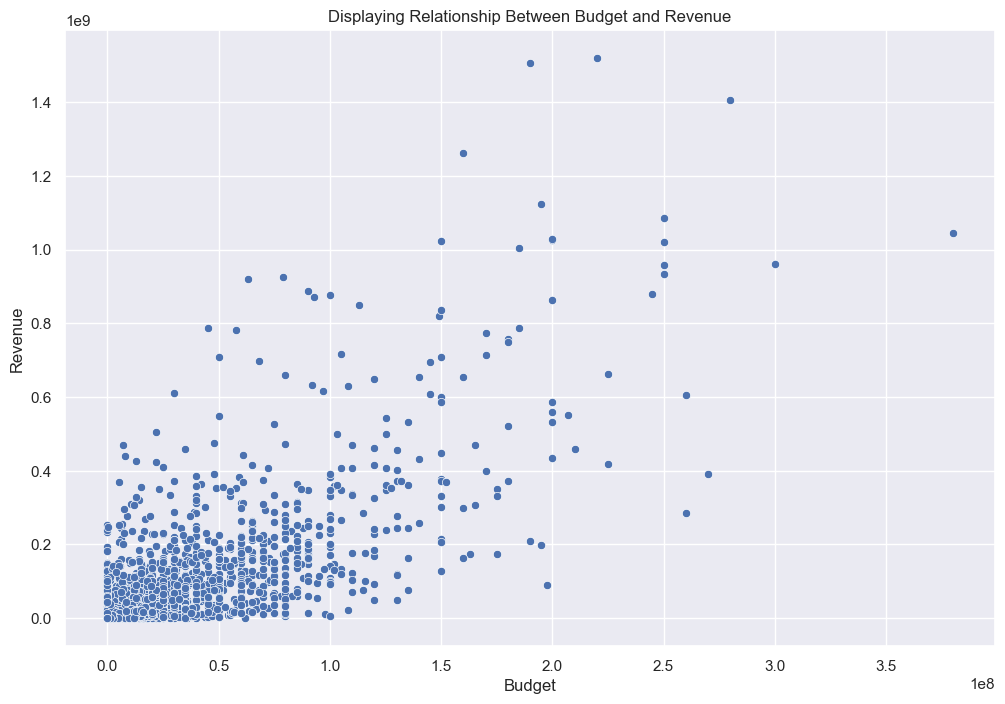

In [135]:
#Association between budget and revenue

sns.scatterplot(x=train['budget'], y=train['revenue'])

# Set titles and labels
plt.title('Displaying Relationship Between Budget and Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')

# Show the plot
plt.show()

This shows that there are many low budget movie that could hamper our analysis. Hence, we are going to remove all low-budget movies, and use a log scale for better visualization.

In [136]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

(array([ 16.,   7.,  15.,  34.,  25.,  47.,  55.,  89., 127., 152., 154.,
        239., 264., 268., 211., 201., 143.,  64.,  34.,   6.]),
 array([11.51293546, 11.92507278, 12.3372101 , 12.74934742, 13.16148473,
        13.57362205, 13.98575937, 14.39789669, 14.810034  , 15.22217132,
        15.63430864, 16.04644596, 16.45858327, 16.87072059, 17.28285791,
        17.69499523, 18.10713254, 18.51926986, 18.93140718, 19.3435445 ,
        19.75568181]),
 <BarContainer object of 20 artists>)

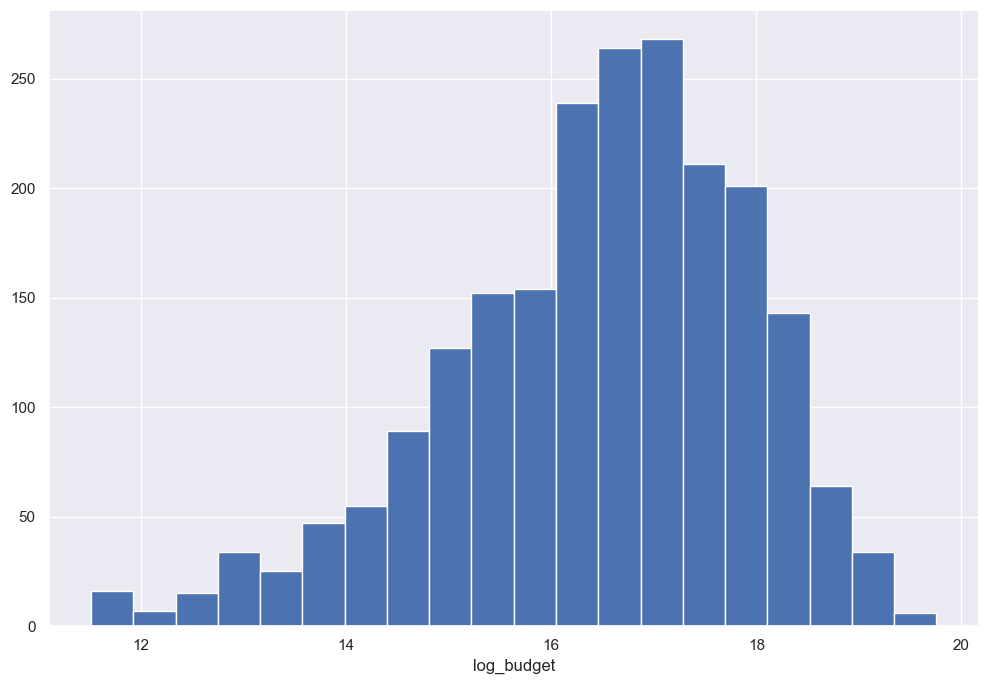

In [137]:
train = train[train['budget'] >= 100000]

plt.xlabel( 'log_budget')
plt.hist(train['log_budget'],bins = 20)

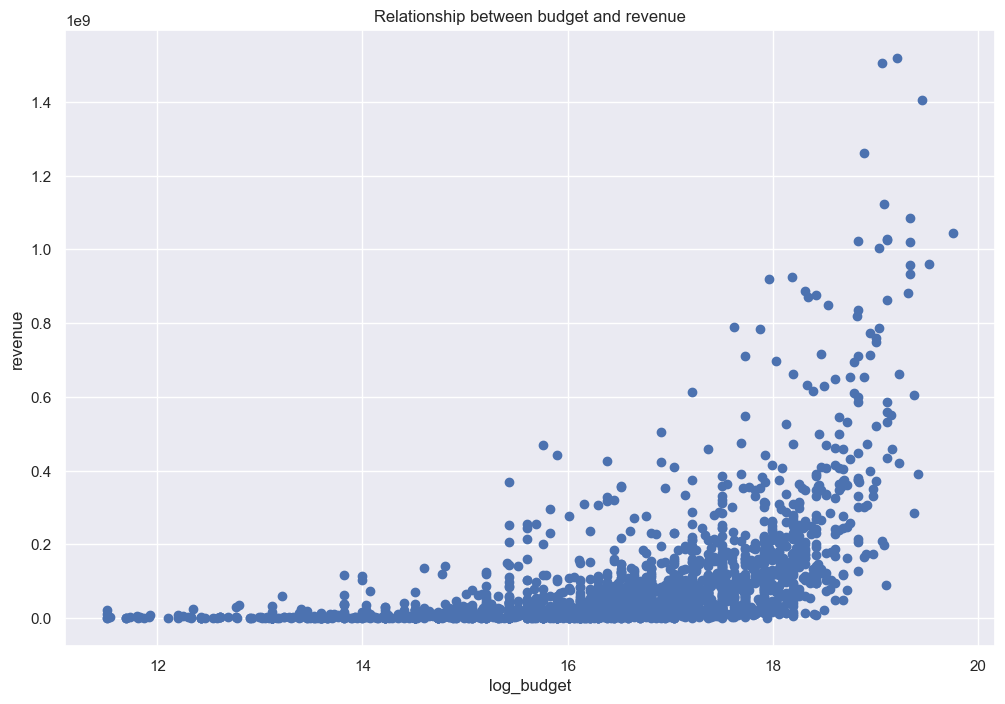

In [138]:
plt.figure(figsize=(12, 8)) 
plt.title('Relationship between budget and revenue')
plt.xlabel( 'log_budget')
plt.ylabel('revenue')
plt.scatter(x=train['log_budget'], y=train['revenue'])

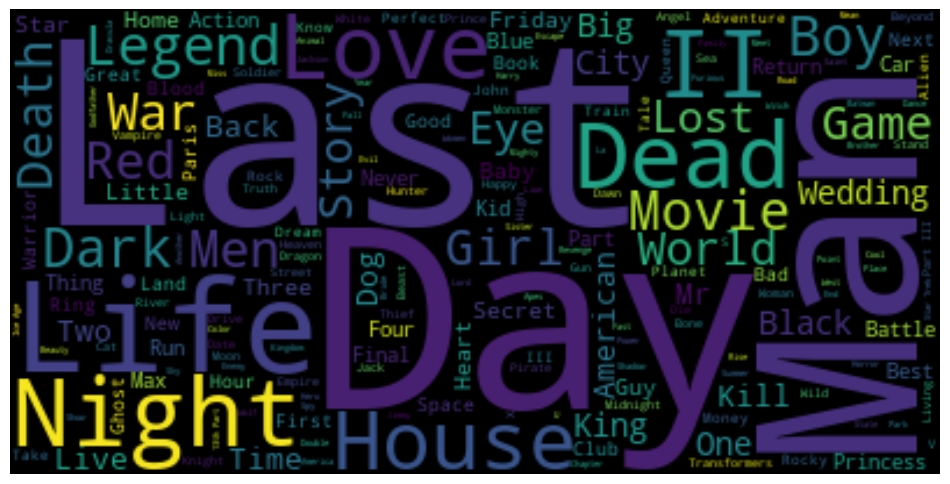

In [139]:
#words that appear in the title
wordcloud = WordCloud().generate(train.title.to_string())

sns.set(rc={'figure.figsize':(12,8)})

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

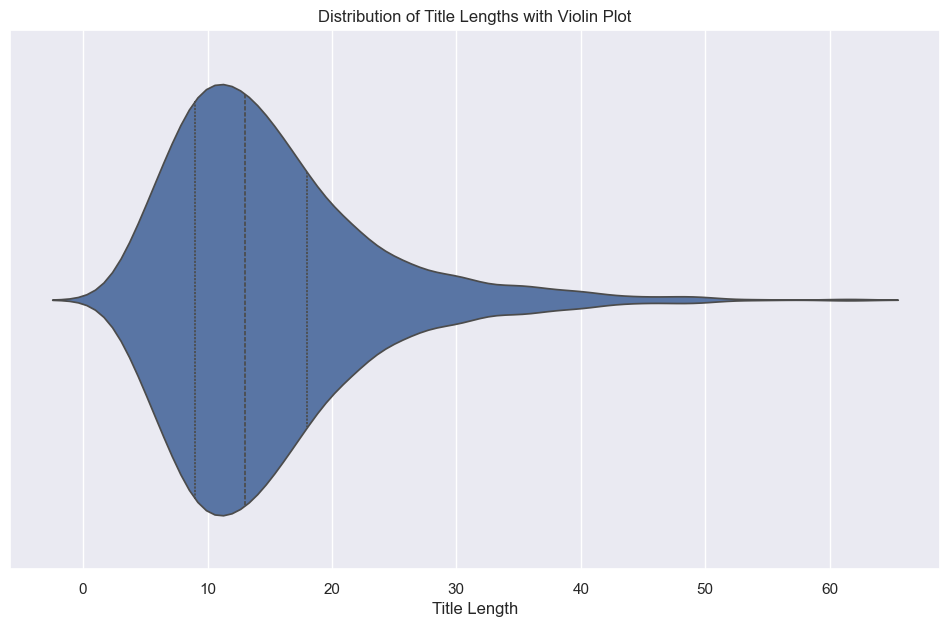

In [140]:
train["title"] = train["title"].fillna("")
test["title"] = test["title"].fillna("")

train["title_len"] = train["title"].apply(len)
test["title_len"] = test["title"].apply(len)

# Create a violin plot to visualize the distribution of title lengths
plt.figure(figsize=(12, 7))
sns.violinplot(x=train["title_len"], inner="quartile")
plt.title("Distribution of Title Lengths with Violin Plot")
plt.xlabel("Title Length")
plt.show()

In [141]:
#preproceess data onto clean format

In [142]:
#Exploratory Data Analysis beforehand

In [143]:
#train model #1 (Random Forest) and run prediction on test set

In [144]:
#train model #2 (simple Linear Regression) and run prediction on test set

In [145]:
#compare performance of two models

#### Final Wrapup